# org data 

In [13]:
user1_folder='../data/button_sequence/user1'

In [14]:
import os
import glob

# Count CSV files
csv_files = glob.glob(os.path.join(user1_folder, '*.csv'))
print(f'Number of CSV files: {len(csv_files)}')

# Count WAV files
wav_files = glob.glob(os.path.join(user1_folder, '*.wav'))
print(f'Number of WAV files: {len(wav_files)}')

Number of CSV files: 102
Number of WAV files: 102


In [68]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
import torch
from typing import List, Dict, Tuple
from dataclasses import dataclass,field
from scipy.signal import savgol_filter, hilbert
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpecFromSubplotSpec

@dataclass
class DatasetConfig:
    inertial_sequence_length: int = 500  # Fixed sequence length for inertial data
    audio_sequence_length: int = 100000  # Fixed sequence length for audio data
    audio_sr: int = 48000  # Audio sampling rate
    n_mfcc: int = 13  # Number of MFCC features
    n_fft: int = 1024  # FFT window size for spectrogram
    hop_length: int = 512  # Hop length for spectrogram
    noise_duration_ms: int = 50  # Duration of noise sample in milliseconds
    inertial_columns: List[str] = field(default_factory=lambda: [
        'gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z'
    ])

class FeatureExtractor:
    def __init__(self, config: DatasetConfig):
        self.config = config
    
    def compute_derivatives_rms(self, data: np.ndarray) -> np.ndarray:
        """
        Compute 1st and 2nd derivatives and their RMS values
        Args:
            data: Raw inertial data of shape (sequence_length, 6)
        Returns:
            RMS features of shape (sequence_length-2, 12)
        """
        # First derivative
        d1 = np.diff(data, axis=0)
        # Second derivative
        d2 = np.diff(d1, axis=0)
        
        # Compute RMS for both derivatives
        d1_rms = np.sqrt(d1[:-1] ** 2)  # shape: (sequence_length - 2, 6)
        d2_rms = np.sqrt(d2 ** 2)       # shape: (sequence_length - 2, 6)
        return np.hstack([d1_rms, d2_rms])  # shape: (sequence_length - 2, 12)
    
    def process_inertial_data(self, csv_path: str) -> Tuple[np.ndarray, np.ndarray, int]:
        """
        Process inertial data from CSV file
        Returns:
            Tuple of (raw_data, derivative_rms, original_length)
        """
        # Read CSV
        df = pd.read_csv(csv_path)
        data = df[self.config.inertial_columns].values
        
        # Store original length
        original_length = len(data)
        
        # Truncate or pad to fixed length
        if len(data) > self.config.inertial_sequence_length:
            data = data[:self.config.inertial_sequence_length]
        else:
            pad_length = self.config.inertial_sequence_length - len(data)
            data = np.pad(data, ((0, pad_length), (0, 0)), mode='constant')
        
        # Compute derivatives RMS
        deriv_rms = self.compute_derivatives_rms(data)
        
        return data, deriv_rms, original_length
    
    def denoise_audio_fixed_noise_sample(self, audio: np.ndarray) -> np.ndarray:
        """
        Apply denoising using a fixed noise sample from the first 100ms of the audio
        Args:
            audio: Raw audio signal
        Returns:
            Denoised audio signal
        """
        # Calculate number of samples for noise profile
        noise_samples = int(self.config.noise_duration_ms * self.config.audio_sr / 1000)
        
        # Extract noise profile from the first segment
        noise = audio[:noise_samples]
        noise_power = np.mean(noise**2)
        
        # Initialize denoised audio
        denoised_audio = np.zeros_like(audio)
        
        # Process audio in overlapping windows
        window_size = 1024
        hop_size = window_size // 2
        
        # Process audio in windows
        for pos in range(0, len(audio) - window_size + 1, hop_size):
            # Extract current window
            window = audio[pos:pos + window_size]
            
            # Apply fixed noise profile subtraction
            window_power = np.mean(window**2)
            
            # Calculate gain based on noise profile
            gain = np.maximum(0, 1 - (noise_power / (window**2 + 1e-10)))
            denoised_window = window * gain
            
            # Apply smoothing to reduce artifacts
            if len(denoised_window) > 3:
                denoised_window = savgol_filter(denoised_window, min(5, len(denoised_window) - (len(denoised_window) % 2 - 1)), 2)
            
            # Add to output with overlap-add
            denoised_audio[pos:pos + window_size] += denoised_window * np.hanning(window_size)
        
        # Normalize for overlap-add
        normalization = np.zeros_like(audio)
        hann_window = np.hanning(window_size)
        
        for pos in range(0, len(audio) - window_size + 1, hop_size):
            normalization[pos:pos + window_size] += hann_window
        
        # Avoid division by zero
        normalization[normalization < 1e-10] = 1.0
        
        denoised_audio /= normalization
        
        return denoised_audio
    
    def compute_cvoca_features(self, audio: np.ndarray) -> np.ndarray:
        """
        Compute CVOCA (Complex-Valued Convolution Analysis) features
        Args:
            audio: Denoised audio signal
        Returns:
            CVOCA magnitude features
        """
        # Get analytic (complex) signal
        analytic = hilbert(audio)
        real_part = np.real(analytic)
        imag_part = np.imag(analytic)
        
        # Define a complex-valued kernel (example: phase edge detector)
        kernel_real = np.array([1, 0, -1])
        kernel_imag = np.array([-1, 0, 1])
        
        # Perform complex convolution
        cvoca_real = np.convolve(real_part, kernel_real, mode='valid') - np.convolve(imag_part, kernel_imag, mode='valid')
        cvoca_imag = np.convolve(real_part, kernel_imag, mode='valid') + np.convolve(imag_part, kernel_real, mode='valid')
        
        # Compute magnitude
        cvoca_magnitude = np.sqrt(cvoca_real**2 + cvoca_imag**2)
        
        return cvoca_magnitude
    
    def process_audio_data(self, wav_path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, int]:
        """
        Process audio data from WAV file
        Args:
            wav_path: Path to WAV file
        Returns:
            Tuple of (raw_audio, denoised_audio, original_spec, denoised_spec, original_mfcc, denoised_mfcc, cvoca_features, original_length)
        """
        # Load audio
        audio, sr = librosa.load(wav_path, sr=self.config.audio_sr)
        
        # Store original length
        original_length = len(audio)
        
        # Truncate or pad to fixed length
        if len(audio) > self.config.audio_sequence_length:
            audio = audio[:self.config.audio_sequence_length]
        else:
            audio = np.pad(audio, (0, self.config.audio_sequence_length - len(audio)))
        
        # Apply fixed noise sample denoising
        denoised_audio = self.denoise_audio_fixed_noise_sample(audio)
        
        # Compute CVOCA features from denoised audio
        cvoca_features = self.compute_cvoca_features(denoised_audio)
        
        # Compute original spectrogram using scipy.signal
        f_orig, t_orig, original_spec = signal.spectrogram(
            audio, 
            fs=self.config.audio_sr, 
            nperseg=self.config.n_fft, 
            noverlap=self.config.n_fft - self.config.hop_length
        )
        
        # Compute denoised spectrogram using scipy.signal
        f_denoised, t_denoised, denoised_spec = signal.spectrogram(
            denoised_audio, 
            fs=self.config.audio_sr, 
            nperseg=self.config.n_fft, 
            noverlap=self.config.n_fft - self.config.hop_length
        )
        
        # Compute original MFCC
        original_mfcc = librosa.feature.mfcc(y=audio, sr=sr, 
                                          n_mfcc=self.config.n_mfcc)
        
        # Compute denoised MFCC
        denoised_mfcc = librosa.feature.mfcc(y=denoised_audio, sr=sr, 
                                          n_mfcc=self.config.n_mfcc)
        
        return audio, denoised_audio, original_spec, denoised_spec, original_mfcc, denoised_mfcc, cvoca_features, original_length

def prepare_dataset(folder_list: List[str], label_list: List[int], 
                   config: DatasetConfig = DatasetConfig(), plot: bool = False) -> Dict:
    """
    Prepare dataset from multiple folders with corresponding labels
    Args:
        folder_list: List of folder paths containing CSV and WAV files
        label_list: List of labels corresponding to each folder
        config: Dataset configuration
        plot: Whether to plot the distribution of original lengths and samples
    Returns:
        Dictionary containing processed features and labels
    """
    feature_extractor = FeatureExtractor(config)
    
    # First pass: collect all original lengths for plotting purposes
    inertial_lengths = []
    audio_lengths = []
    all_csv_files = []
    
    for folder in folder_list:
        csv_files = glob.glob(os.path.join(folder, '*.csv'))
        
        for csv_file in csv_files:
            wav_file = csv_file.replace('.csv', '.wav')
            if not os.path.exists(wav_file):
                continue
                
            try:
                # Read CSV to get inertial data length
                df = pd.read_csv(csv_file)
                inertial_lengths.append(len(df))
                
                # Load audio to get audio length
                audio, _ = librosa.load(wav_file, sr=config.audio_sr)
                audio_lengths.append(len(audio))
                
                all_csv_files.append((csv_file, wav_file))
                
            except Exception as e:
                continue
    
    # Plot distribution of original lengths
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.hist(inertial_lengths, bins=20)
        plt.axvline(x=config.inertial_sequence_length, color='r', linestyle='--', 
                   label=f'Fixed length: {config.inertial_sequence_length}')
        min_inertial_length = min(inertial_lengths) if inertial_lengths else 0
        plt.axvline(x=min_inertial_length, color='g', linestyle='--', 
                   label=f'Min length: {min_inertial_length}')
        plt.title('Distribution of Original Inertial Data Lengths')
        plt.xlabel('Length')
        plt.ylabel('Count')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.hist(audio_lengths, bins=20)
        plt.axvline(x=config.audio_sequence_length, color='r', linestyle='--', 
                   label=f'Fixed length: {config.audio_sequence_length}')
        min_audio_length = min(audio_lengths) if audio_lengths else 0
        plt.axvline(x=min_audio_length, color='g', linestyle='--', 
                   label=f'Min length: {min_audio_length}')
        plt.title('Distribution of Original Audio Lengths')
        plt.xlabel('Length')
        plt.ylabel('Count')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # Process all files with the fixed lengths from config
    dataset = {
        'inertial_raw': [],
        'derivative_rms': [],
        'audio_raw': [],
        'audio_denoised': [],
        'spectrogram_original': [],
        'spectrogram_denoised': [],
        'mfcc_original': [],
        'mfcc_denoised': [],
        'cvoca_features': [],
        'labels': [],
        'inertial_original_lengths': [],
        'audio_original_lengths': []
    }
    
    label_map = {folder: label for folder, label in zip(folder_list, label_list)}
    
    for csv_file, wav_file in all_csv_files:
        try:
            # Process inertial data
            inertial_raw, deriv_rms, inertial_orig_len = feature_extractor.process_inertial_data(csv_file)
            
            # Process audio data with the fixed length from config
            audio_raw, audio_denoised, spec_orig, spec_denoised, mfcc_orig, mfcc_denoised, cvoca_features, audio_orig_len = feature_extractor.process_audio_data(wav_file)
            
            # Determine label based on folder
            folder = os.path.dirname(csv_file)
            label = next((label_map[f] for f in label_map if folder.startswith(f)), None)
            
            if label is None:
                continue
                
            # Append to dataset
            dataset['inertial_raw'].append(inertial_raw)
            dataset['derivative_rms'].append(deriv_rms)
            dataset['audio_raw'].append(audio_raw)
            dataset['audio_denoised'].append(audio_denoised)
            dataset['spectrogram_original'].append(spec_orig)
            dataset['spectrogram_denoised'].append(spec_denoised)
            dataset['mfcc_original'].append(mfcc_orig)
            dataset['mfcc_denoised'].append(mfcc_denoised)
            dataset['cvoca_features'].append(cvoca_features)
            dataset['labels'].append(label)
            dataset['inertial_original_lengths'].append(inertial_orig_len)
            dataset['audio_original_lengths'].append(audio_orig_len)
            
        except Exception as e:
            continue
    
    # Convert lists to numpy arrays
    for key in dataset:
        dataset[key] = np.array(dataset[key])
    
    # Print information about feature shapes
    print("\n=== Dataset Feature Shapes ===")
    print(f"Number of samples: {len(dataset['labels'])}")
    print(f"Inertial raw data: {dataset['inertial_raw'].shape}")
    print(f"Derivative RMS: {dataset['derivative_rms'].shape}")
    print(f"Audio raw: {dataset['audio_raw'].shape}")
    print(f"Audio denoised: {dataset['audio_denoised'].shape}")
    print(f"Spectrogram original: {dataset['spectrogram_original'].shape}")
    print(f"Spectrogram denoised: {dataset['spectrogram_denoised'].shape}")
    print(f"MFCC original: {dataset['mfcc_original'].shape}")
    print(f"MFCC denoised: {dataset['mfcc_denoised'].shape}")
    print(f"CVOCA features: {dataset['cvoca_features'].shape}")
    print(f"Labels: {dataset['labels'].shape}")
    print("============================\n")
    
    # Plot the first 10 samples of original and denoised spectrograms and MFCCs if requested
    if plot and len(dataset['spectrogram_original']) > 0 and len(dataset['mfcc_original']) > 0:
        num_samples = min(10, len(dataset['spectrogram_original']))
        fig, axes = plt.subplots(5, num_samples, figsize=(20, 6))
        
        # Plot original spectrograms in the first row using scipy.signal
        for i in range(num_samples):
            # Use pcolormesh for better visualization of spectrograms
            im = axes[0, i].pcolormesh(10 * np.log10(dataset['spectrogram_original'][i] + 1e-10), cmap='viridis')
            axes[0, i].set_title(f'Original Spec {i+1}')
            axes[0, i].set_xlabel('')
            axes[0, i].set_ylabel('') if i > 0 else axes[0, i].set_ylabel('Frequency')
            # Set y-axis limit to show frequencies from 0 to 12000 Hz
            max_freq_idx = int(12000 * dataset['spectrogram_original'][i].shape[0] / (config.audio_sr/2))
            axes[0, i].set_ylim(0, max_freq_idx)
        
        # Plot denoised spectrograms in the second row using scipy.signal
        for i in range(num_samples):
            im = axes[1, i].pcolormesh(10 * np.log10(dataset['spectrogram_denoised'][i] + 1e-10), cmap='viridis')
            axes[1, i].set_title(f'Denoised Spec {i+1}')
            axes[1, i].set_xlabel('')
            axes[1, i].set_ylabel('') if i > 0 else axes[1, i].set_ylabel('Frequency')
            # Set y-axis limit to show frequencies from 0 to 12000 Hz
            max_freq_idx = int(12000 * dataset['spectrogram_denoised'][i].shape[0] / (config.audio_sr/2))
            axes[1, i].set_ylim(0, max_freq_idx)
        
        # Plot peak signal around 60ms in the third row
        for i in range(num_samples):
            # Get the spectrogram data
            spec_data = 10 * np.log10(dataset['spectrogram_denoised'][i] + 1e-10)
            
            # Find the peak power point
            peak_idx = np.unravel_index(np.argmax(spec_data), spec_data.shape)
            
            # Calculate time in ms per spectrogram bin
            time_per_bin = 1000 * config.hop_length / config.audio_sr  # ms per bin
            
            # Calculate how many bins correspond to 60ms
            bins_for_60ms = int(60 / time_per_bin)
            
            # Calculate the range to display (30ms before and after peak)
            start_bin = max(0, peak_idx[1] - bins_for_60ms // 2)
            end_bin = min(spec_data.shape[1], peak_idx[1] + bins_for_60ms // 2)
            
            # Plot the zoomed spectrogram centered on peak
            im = axes[2, i].pcolormesh(spec_data[:, start_bin:end_bin], cmap='viridis')
            axes[2, i].set_title(f'Peak Signal ~60ms {i+1}')
            axes[2, i].set_xlabel('')
            axes[2, i].set_ylabel('') if i > 0 else axes[2, i].set_ylabel('Frequency')
            # Set y-axis limit to show frequencies from 0 to 12000 Hz
            max_freq_idx = int(12000 * spec_data.shape[0] / (config.audio_sr/2))
            axes[2, i].set_ylim(0, max_freq_idx)
        
        # Plot original MFCCs in the fourth row using seaborn
        for i in range(num_samples):
            sns.heatmap(dataset['mfcc_original'][i], cmap='coolwarm', ax=axes[3, i], cbar=False)
            axes[3, i].set_title(f'Original MFCC {i+1}')
            axes[3, i].set_xlabel('')
            axes[3, i].set_ylabel('') if i > 0 else axes[3, i].set_ylabel('MFCC')
            axes[3, i].invert_yaxis()
        
        # Plot denoised MFCCs in the fifth row using seaborn
        for i in range(num_samples):
            sns.heatmap(dataset['mfcc_denoised'][i], cmap='coolwarm', ax=axes[4, i], cbar=False)
            axes[4, i].set_title(f'Denoised MFCC {i+1}')
            axes[4, i].set_xlabel('Time')
            axes[4, i].set_ylabel('') if i > 0 else axes[4, i].set_ylabel('MFCC')
            axes[4, i].invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
        # Plot CVOCA features for the first few samples
        plt.figure(figsize=(15, 5))
        for i in range(min(5, len(dataset['cvoca_features']))):
            plt.subplot(1, 5, i+1)
            plt.plot(dataset['cvoca_features'][i])
            plt.title(f'CVOCA Sample {i+1}')
            if i == 0:
                plt.ylabel('Magnitude')
            plt.xlabel('Time')
        plt.tight_layout()
        plt.show()
    
    return dataset

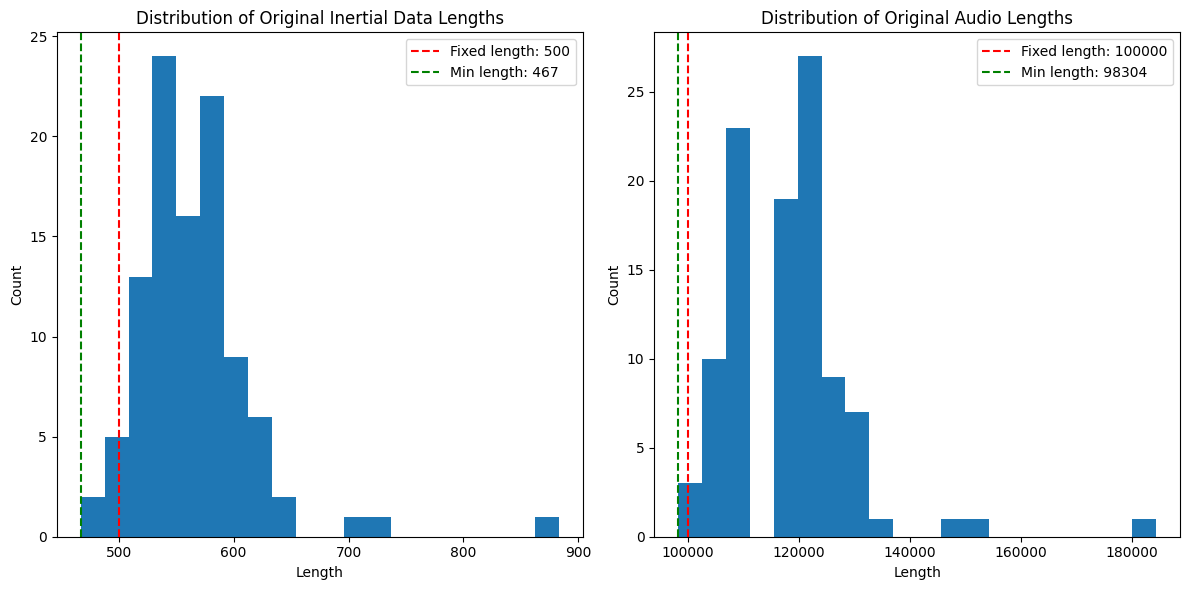


=== Dataset Feature Shapes ===
Number of samples: 102
Inertial raw data: (102, 500, 6)
Derivative RMS: (102, 498, 12)
Audio raw: (102, 100000)
Audio denoised: (102, 100000)
Spectrogram original: (102, 513, 194)
Spectrogram denoised: (102, 513, 194)
MFCC original: (102, 13, 196)
MFCC denoised: (102, 13, 196)
CVOCA features: (102, 99998)
Labels: (102,)



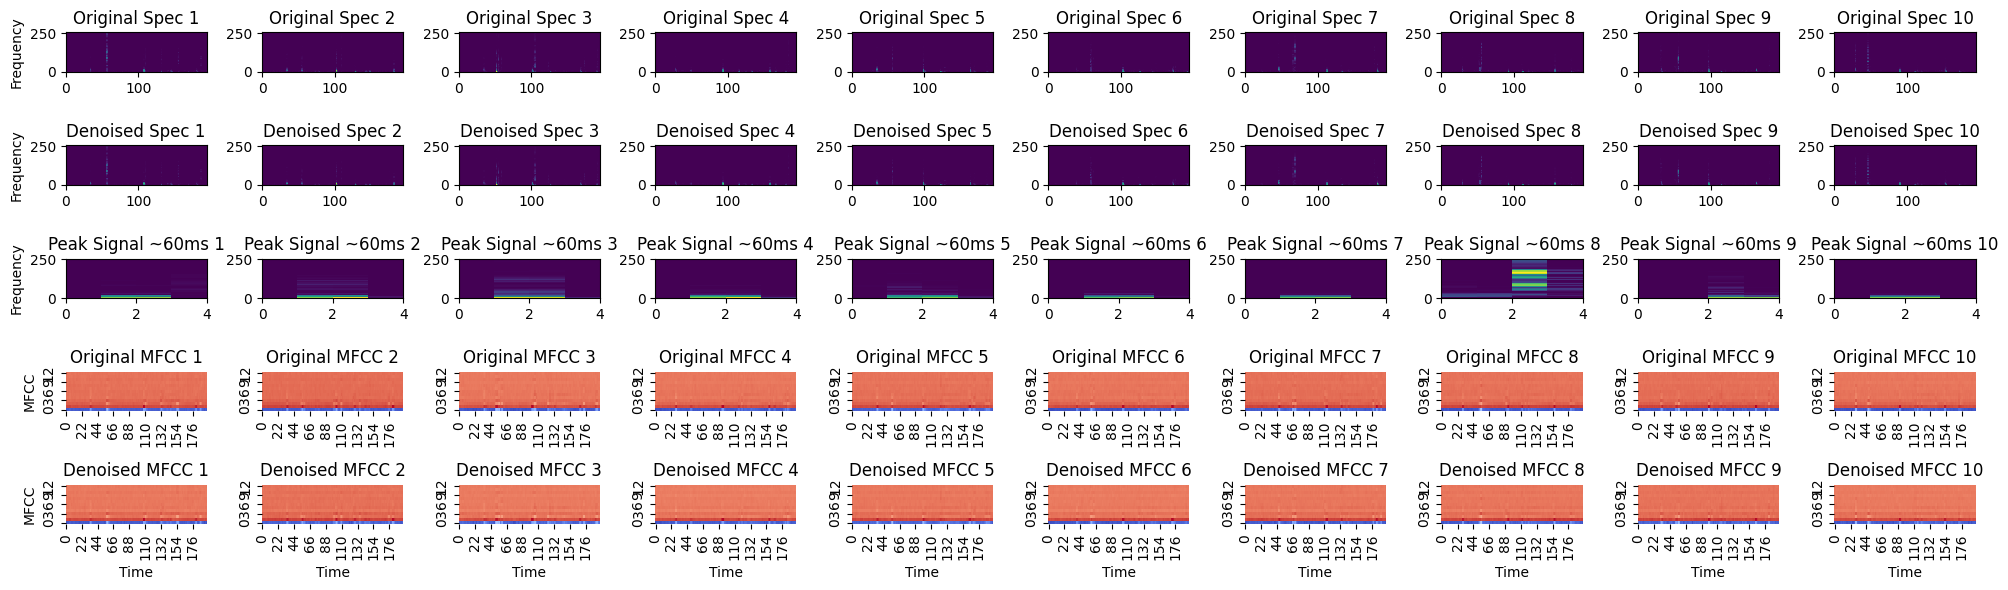

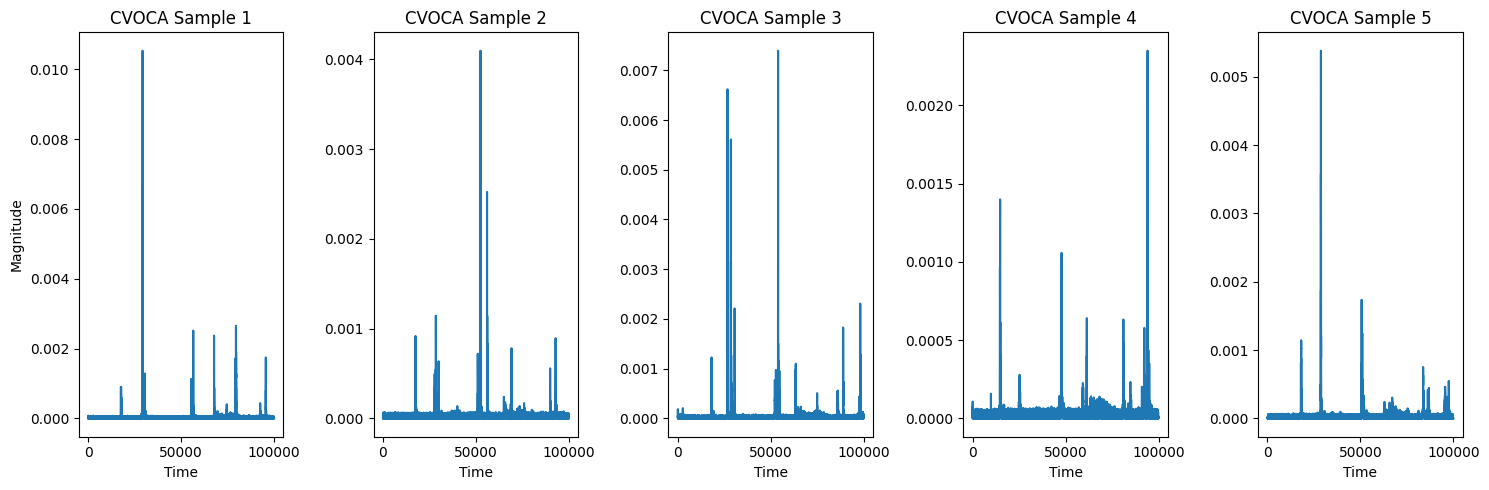

In [69]:
config = DatasetConfig()

folders=['../data/button_sequence/user1']
labels=[0]

dataset = prepare_dataset(folders, labels, config, plot=True)



In [46]:
import math
import torch
import torch.nn as nn
from typing import Tuple

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # [1, max_len, d_model] so it can broadcast over batch
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]  # broadcast add
        return self.dropout(x)

class TransformerAutoencoder(nn.Module):
    def __init__(self, 
                 d_rms_dim: int = 12,
                 mfcc_dim: int = 13,
                 seq_len: int = 196,
                 d_model: int = 256,
                 nhead: int = 8,
                 num_layers: int = 4,
                 dropout: float = 0.1):
        super().__init__()
        
        # Input projections
        self.d_rms_proj = nn.Linear(d_rms_dim, d_model)
        self.mfcc_proj = nn.Linear(mfcc_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projections
        self.d_rms_decoder = nn.Linear(d_model, d_rms_dim)
        self.mfcc_decoder = nn.Linear(d_model, mfcc_dim)
        
    def forward(self, d_rms: torch.Tensor, mfcc: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        d_rms_emb = self.d_rms_proj(d_rms)   # [B, T, d_model]
        mfcc_emb = self.mfcc_proj(mfcc)      # [B, T, d_model]
        
        combined = torch.cat([d_rms_emb, mfcc_emb], dim=1)  # [B, 2T, d_model]
        combined = self.pos_encoder(combined)               # Add positional encodings
        encoded = self.transformer_encoder(combined)        # [B, 2T, d_model]
        
        d_rms_encoded = encoded[:, :d_rms.size(1), :]       # [B, T, d_model]
        mfcc_encoded = encoded[:, d_rms.size(1):, :]        # [B, T, d_model]
        
        d_rms_recon = self.d_rms_decoder(d_rms_encoded)     # [B, T, d_rms_dim]
        mfcc_recon = self.mfcc_decoder(mfcc_encoded)        # [B, T, mfcc_dim]
        
        return d_rms_recon, mfcc_recon

class LSTMAutoencoder(nn.Module):
    def __init__(self,
                 d_rms_dim: int = 12,
                 mfcc_dim: int = 13,
                 hidden_dim: int = 256,
                 num_layers: int = 2,
                 dropout: float = 0.1):
        super().__init__()
        
        self.d_rms_proj = nn.Linear(d_rms_dim, hidden_dim)
        self.mfcc_proj = nn.Linear(mfcc_dim, hidden_dim)
        
        self.encoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.decoder = nn.LSTM(
            input_size=hidden_dim * 2,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.d_rms_decoder = nn.Linear(hidden_dim, d_rms_dim)
        self.mfcc_decoder = nn.Linear(hidden_dim, mfcc_dim)
        
    def forward(self, d_rms: torch.Tensor, mfcc: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        d_rms_emb = self.d_rms_proj(d_rms)   # [B, T, hidden]
        mfcc_emb = self.mfcc_proj(mfcc)      # [B, T, hidden]
        
        combined = torch.cat([d_rms_emb, mfcc_emb], dim=1)  # [B, 2T, hidden]
        
        # Encoding
        encoded, _ = self.encoder(combined)  # BiLSTM → [B, 2T, 2*hidden]
        
        # Decoding (no hidden state passed)
        decoded, _ = self.decoder(encoded)   # [B, 2T, hidden]
        
        d_rms_encoded = decoded[:, :d_rms.size(1), :]
        mfcc_encoded = decoded[:, d_rms.size(1):, :]
        
        d_rms_recon = self.d_rms_decoder(d_rms_encoded)
        mfcc_recon = self.mfcc_decoder(mfcc_encoded)
        
        return d_rms_recon, mfcc_recon



In [47]:
# Transformer model
transformer_model = TransformerAutoencoder(
    d_rms_dim=12,
    mfcc_dim=13,
    seq_len=196,
    d_model=256,
    nhead=8,
    num_layers=4
)

# LSTM model
lstm_model = LSTMAutoencoder(
    d_rms_dim=12,
    mfcc_dim=13,
    hidden_dim=256,
    num_layers=2
)

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import time
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import numpy as np
import torch
import pandas as pd

# Custom Dataset class
class MultiModalDataset(Dataset):
    def __init__(self, d_rms_data: np.ndarray, mfcc_data: np.ndarray):
        # Ensure MFCC is in the right shape (batch, seq_len, features)
        if mfcc_data.shape[1] == 13:  # If shape is (batch, 13, 196)
            mfcc_data = np.transpose(mfcc_data, (0, 2, 1))
        
        self.d_rms = torch.FloatTensor(d_rms_data)
        self.mfcc = torch.FloatTensor(mfcc_data)
        
    def __len__(self):
        return len(self.d_rms)
    
    def __getitem__(self, idx):
        return self.d_rms[idx], self.mfcc[idx]

class ModelTrainer:
    def __init__(self, model: nn.Module, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(model.parameters())
        self.criterion = nn.MSELoss()
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'd_rms_mse': [],
            'mfcc_mse': [],
            'd_rms_r2': [],
            'mfcc_r2': []
        }
    
    def train_epoch(self, train_loader: DataLoader) -> float:
        self.model.train()
        total_loss = 0
        
        for d_rms, mfcc in train_loader:
            d_rms, mfcc = d_rms.to(self.device), mfcc.to(self.device)
            
            # Forward pass
            d_rms_recon, mfcc_recon = self.model(d_rms, mfcc)
            
            # Calculate loss
            d_rms_loss = self.criterion(d_rms_recon, d_rms)
            mfcc_loss = self.criterion(mfcc_recon, mfcc)
            loss = d_rms_loss + mfcc_loss
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
        
        return total_loss / len(train_loader)
    
    @torch.no_grad()
    def evaluate(self, val_loader: DataLoader) -> Tuple[float, Dict[str, float]]:
        self.model.eval()
        total_loss = 0
        all_d_rms = []
        all_d_rms_recon = []
        all_mfcc = []
        all_mfcc_recon = []
        
        for d_rms, mfcc in val_loader:
            d_rms, mfcc = d_rms.to(self.device), mfcc.to(self.device)
            
            # Forward pass
            d_rms_recon, mfcc_recon = self.model(d_rms, mfcc)
            
            # Calculate loss
            d_rms_loss = self.criterion(d_rms_recon, d_rms)
            mfcc_loss = self.criterion(mfcc_recon, mfcc)
            loss = d_rms_loss + mfcc_loss
            
            total_loss += loss.item()
            
            # Collect predictions for metrics
            all_d_rms.append(d_rms.cpu().numpy())
            all_d_rms_recon.append(d_rms_recon.cpu().numpy())
            all_mfcc.append(mfcc.cpu().numpy())
            all_mfcc_recon.append(mfcc_recon.cpu().numpy())
        
        # Concatenate all predictions
        all_d_rms = np.concatenate(all_d_rms)
        all_d_rms_recon = np.concatenate(all_d_rms_recon)
        all_mfcc = np.concatenate(all_mfcc)
        all_mfcc_recon = np.concatenate(all_mfcc_recon)
        
        # Calculate metrics
        metrics = {
            'd_rms_mse': mean_squared_error(all_d_rms.reshape(-1), all_d_rms_recon.reshape(-1)),
            'mfcc_mse': mean_squared_error(all_mfcc.reshape(-1), all_mfcc_recon.reshape(-1)),
            'd_rms_r2': r2_score(all_d_rms.reshape(-1), all_d_rms_recon.reshape(-1)),
            'mfcc_r2': r2_score(all_mfcc.reshape(-1), all_mfcc_recon.reshape(-1))
        }
        
        return total_loss / len(val_loader), metrics
    
    def train(self, train_loader: DataLoader, val_loader: DataLoader, 
              num_epochs: int = 50, early_stopping_patience: int = 5) -> Dict:
        best_val_loss = float('inf')
        patience_counter = 0
        start_time = time.time()
        
        for epoch in range(num_epochs):
            # Train
            train_loss = self.train_epoch(train_loader)
            
            # Evaluate
            val_loss, metrics = self.evaluate(val_loader)
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['d_rms_mse'].append(metrics['d_rms_mse'])
            self.history['mfcc_mse'].append(metrics['mfcc_mse'])
            self.history['d_rms_r2'].append(metrics['d_rms_r2'])
            self.history['mfcc_r2'].append(metrics['mfcc_r2'])
            
            # Print progress (all in one line)
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, D-RMS MSE: {metrics['d_rms_mse']:.4f}, MFCC MSE: {metrics['mfcc_mse']:.4f}, D-RMS R2: {metrics['d_rms_r2']:.4f}, MFCC R2: {metrics['mfcc_r2']:.4f}")
            
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
        
        # Final plot of training history
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.history['d_rms_mse'], label='D-RMS MSE')
        plt.plot(self.history['mfcc_mse'], label='MFCC MSE')
        plt.title('MSE by Feature Type')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return self.history

def plot_training_history(transformer_history: Dict, lstm_history: Dict):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot losses
    axes[0, 0].plot(transformer_history['train_loss'], label='Transformer Train')
    axes[0, 0].plot(transformer_history['val_loss'], label='Transformer Val')
    axes[0, 0].plot(lstm_history['train_loss'], label='LSTM Train')
    axes[0, 0].plot(lstm_history['val_loss'], label='LSTM Val')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    
    # Plot MSE
    axes[0, 1].plot(transformer_history['d_rms_mse'], label='Transformer D-RMS')
    axes[0, 1].plot(transformer_history['mfcc_mse'], label='Transformer MFCC')
    axes[0, 1].plot(lstm_history['d_rms_mse'], label='LSTM D-RMS')
    axes[0, 1].plot(lstm_history['mfcc_mse'], label='LSTM MFCC')
    axes[0, 1].set_title('MSE by Feature Type')
    axes[0, 1].legend()
    
    # Plot R2 scores
    axes[1, 0].plot(transformer_history['d_rms_r2'], label='Transformer D-RMS')
    axes[1, 0].plot(transformer_history['mfcc_r2'], label='Transformer MFCC')
    axes[1, 0].plot(lstm_history['d_rms_r2'], label='LSTM D-RMS')
    axes[1, 0].plot(lstm_history['mfcc_r2'], label='LSTM MFCC')
    axes[1, 0].set_title('R² Score by Feature Type')
    axes[1, 0].legend()
    
    # Add final metrics comparison
    final_metrics = {
        'Transformer': {
            'D-RMS MSE': transformer_history['d_rms_mse'][-1],
            'MFCC MSE': transformer_history['mfcc_mse'][-1],
            'D-RMS R2': transformer_history['d_rms_r2'][-1],
            'MFCC R2': transformer_history['mfcc_r2'][-1]
        },
        'LSTM': {
            'D-RMS MSE': lstm_history['d_rms_mse'][-1],
            'MFCC MSE': lstm_history['mfcc_mse'][-1],
            'D-RMS R2': lstm_history['d_rms_r2'][-1],
            'MFCC R2': lstm_history['mfcc_r2'][-1]
        }
    }
    
    axes[1, 1].axis('off')
    axes[1, 1].text(0.1, 0.9, 'Final Metrics Comparison', fontsize=12, fontweight='bold')
    y_pos = 0.8
    for model, metrics in final_metrics.items():
        axes[1, 1].text(0.1, y_pos, f'\n{model}:', fontsize=10, fontweight='bold')
        y_pos -= 0.1
        for metric, value in metrics.items():
            axes[1, 1].text(0.2, y_pos, f'{metric}: {value:.4f}')
            y_pos -= 0.1
    
    plt.tight_layout()
    plt.show()

def compute_fareer(y_true, y_pred, threshold=0.5):
    y_true_bin = np.array(y_true)
    y_pred_bin = (np.array(y_pred) > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin).ravel()

    FAR = fp / (fp + tn + 1e-10)
    FRR = fn / (fn + tp + 1e-10)
    EER = (FAR + FRR) / 2
    ACC = (tp + tn) / (tp + tn + fp + fn)
    F1 = f1_score(y_true_bin, y_pred_bin)

    return {
        'FAR': FAR,
        'FRR': FRR,
        'EER': EER,
        'ACC': ACC,
        'F1': F1
    }

def train_autoencoders_per_label(dataset: dict,
                                  batch_size=32,
                                  num_epochs=50,
                                  early_stopping_patience=5):
    d_rms_data = np.array(dataset['derivative_rms'])  # shape: (N, T, 12)
    mfcc_data = np.array(dataset['mfcc_denoised'])    # shape: (N, 13, T2)
    labels = np.array(dataset['labels'])

    if mfcc_data.shape[1] == 13:
        mfcc_data = np.transpose(mfcc_data, (0, 2, 1))  # shape: (N, T2, 13)

    unique_labels = np.unique(labels)
    print(f"Unique labels in dataset: {unique_labels}\n")

    results_by_label = {}
    all_transformer_metrics = []
    all_lstm_metrics = []

    for label in unique_labels:
        print(f"🟣 Training for label: {label} (target)")
        binary_labels = (labels == label).astype(int)

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            np.arange(len(d_rms_data)), binary_labels, test_size=0.2, random_state=42, stratify=binary_labels
        )

        # Print counts
        train_targets = np.sum(y_train)
        val_targets = np.sum(y_val)
        print(f"Train: {len(X_train)} samples | Targets: {train_targets}")
        print(f"Validation: {len(X_val)} samples | Targets: {val_targets}, Non-targets: {len(X_val) - val_targets}")

        # Prepare dataset splits
        train_dataset = MultiModalDataset(d_rms_data[X_train], mfcc_data[X_train])
        val_dataset = MultiModalDataset(d_rms_data[X_val], mfcc_data[X_val])
        val_labels = binary_labels[X_val]

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Train Transformer
        print("\n🚀 Training TransformerAutoencoder...")
        transformer = TransformerAutoencoder()
        transformer_trainer = ModelTrainer(transformer)
        transformer_history = transformer_trainer.train(train_loader, val_loader, num_epochs, early_stopping_patience)

        # Evaluate Transformer model with thresholded reconstruction error
        transformer_trainer.model.eval()
        recon_errors = []
        true_labels = []

        with torch.no_grad():
            for d_rms, mfcc in val_loader:
                d_rms, mfcc = d_rms.to(transformer_trainer.device), mfcc.to(transformer_trainer.device)
                d_rms_recon, mfcc_recon = transformer_trainer.model(d_rms, mfcc)

                error = ((d_rms_recon - d_rms) ** 2).mean(dim=[1, 2]) + ((mfcc_recon - mfcc) ** 2).mean(dim=[1, 2])
                recon_errors.extend(error.cpu().numpy())

        threshold = np.percentile(recon_errors, 80)  # simple dynamic threshold
        pred_labels = (np.array(recon_errors) < threshold).astype(int)

        transformer_metrics = compute_fareer(val_labels, pred_labels)
        transformer_metrics['label'] = label
        all_transformer_metrics.append(transformer_metrics)
        print(f"Transformer metrics (Label {label}): {transformer_metrics}")

        # Plot validation results for Transformer
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(transformer_history['train_loss'], label='Train Loss')
        plt.plot(transformer_history['val_loss'], label='Validation Loss')
        plt.title('Transformer Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(transformer_history['d_rms_mse'], label='D-RMS MSE')
        plt.plot(transformer_history['mfcc_mse'], label='MFCC MSE')
        plt.title('Transformer MSE by Feature Type')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        # Train LSTM
        print("\n🌀 Training LSTMAutoencoder...")
        lstm = LSTMAutoencoder()
        lstm_trainer = ModelTrainer(lstm)
        lstm_history = lstm_trainer.train(train_loader, val_loader, num_epochs, early_stopping_patience)

        # Evaluate LSTM model with reconstruction error
        lstm_trainer.model.eval()
        recon_errors = []

        with torch.no_grad():
            for d_rms, mfcc in val_loader:
                d_rms, mfcc = d_rms.to(lstm_trainer.device), mfcc.to(lstm_trainer.device)
                d_rms_recon, mfcc_recon = lstm_trainer.model(d_rms, mfcc)

                error = ((d_rms_recon - d_rms) ** 2).mean(dim=[1, 2]) + ((mfcc_recon - mfcc) ** 2).mean(dim=[1, 2])
                recon_errors.extend(error.cpu().numpy())

        threshold = np.percentile(recon_errors, 80)
        pred_labels = (np.array(recon_errors) < threshold).astype(int)

        lstm_metrics = compute_fareer(val_labels, pred_labels)
        lstm_metrics['label'] = label
        all_lstm_metrics.append(lstm_metrics)
        print(f"LSTM metrics (Label {label}): {lstm_metrics}")

        # Plot validation results for LSTM
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(lstm_history['train_loss'], label='Train Loss')
        plt.plot(lstm_history['val_loss'], label='Validation Loss')
        plt.title('LSTM Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(lstm_history['d_rms_mse'], label='D-RMS MSE')
        plt.plot(lstm_history['mfcc_mse'], label='MFCC MSE')
        plt.title('LSTM MSE by Feature Type')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        # Save results
        results_by_label[label] = {
            'transformer': transformer_metrics,
            'lstm': lstm_metrics,
            'transformer_history': transformer_history,
            'lstm_history': lstm_history
        }

        print("=" * 80)
    
    # Create comparison table
    transformer_df = pd.DataFrame(all_transformer_metrics)
    lstm_df = pd.DataFrame(all_lstm_metrics)
    
    # Calculate average metrics
    transformer_avg = transformer_df.drop('label', axis=1).mean().to_dict()
    transformer_avg['label'] = 'Average'
    lstm_avg = lstm_df.drop('label', axis=1).mean().to_dict()
    lstm_avg['label'] = 'Average'
    
    # Add average row
    transformer_df = pd.concat([transformer_df, pd.DataFrame([transformer_avg])])
    lstm_df = pd.concat([lstm_df, pd.DataFrame([lstm_avg])])
    
    # Create comparison table
    comparison_table = pd.DataFrame({
        'Label': transformer_df['label'],
        'Transformer FAR': transformer_df['FAR'],
        'LSTM FAR': lstm_df['FAR'],
        'Transformer FRR': transformer_df['FRR'],
        'LSTM FRR': lstm_df['FRR'],
        'Transformer EER': transformer_df['EER'],
        'LSTM EER': lstm_df['EER'],
        'Transformer ACC': transformer_df['ACC'],
        'LSTM ACC': lstm_df['ACC'],
        'Transformer F1': transformer_df['F1'],
        'LSTM F1': lstm_df['F1']
    })
    
    print("\n📊 Model Comparison Table:")
    print(comparison_table)
    
    # Plot comparison
    plt.figure(figsize=(15, 10))
    
    metrics = ['FAR', 'FRR', 'EER', 'ACC', 'F1']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        
        x = np.arange(len(transformer_df))
        width = 0.35
        
        plt.bar(x - width/2, transformer_df[metric], width, label='Transformer')
        plt.bar(x + width/2, lstm_df[metric], width, label='LSTM')
        
        plt.xlabel('Label')
        plt.ylabel(metric)
        plt.title(f'Comparison of {metric}')
        plt.xticks(x, transformer_df['label'])
        plt.legend()
    
    plt.tight_layout()
    plt.show()

    return results_by_label

Unique labels in dataset: [0]

🟣 Training for label: 0 (target)
Train: 81 samples | Targets: 81
Validation: 21 samples | Targets: 21, Non-targets: 0

🚀 Training TransformerAutoencoder...
Epoch 1/300 - Train Loss: 75042.8438, Val Loss: 75541.1641, D-RMS MSE: 10619.6836, MFCC MSE: 64921.4844, D-RMS R2: -0.0649, MFCC R2: -0.0351
Epoch 2/300 - Train Loss: 74462.4115, Val Loss: 75404.4219, D-RMS MSE: 10594.0605, MFCC MSE: 64810.3555, D-RMS R2: -0.0623, MFCC R2: -0.0334
Epoch 3/300 - Train Loss: 73887.4896, Val Loss: 75233.5703, D-RMS MSE: 10544.9795, MFCC MSE: 64688.5859, D-RMS R2: -0.0574, MFCC R2: -0.0314
Epoch 4/300 - Train Loss: 73836.0026, Val Loss: 75029.5078, D-RMS MSE: 10467.6191, MFCC MSE: 64561.8906, D-RMS R2: -0.0496, MFCC R2: -0.0294
Epoch 5/300 - Train Loss: 73608.0286, Val Loss: 74862.8047, D-RMS MSE: 10422.7334, MFCC MSE: 64440.0664, D-RMS R2: -0.0451, MFCC R2: -0.0275
Epoch 6/300 - Train Loss: 73270.5938, Val Loss: 74702.1094, D-RMS MSE: 10388.0469, MFCC MSE: 64314.0625, D-R

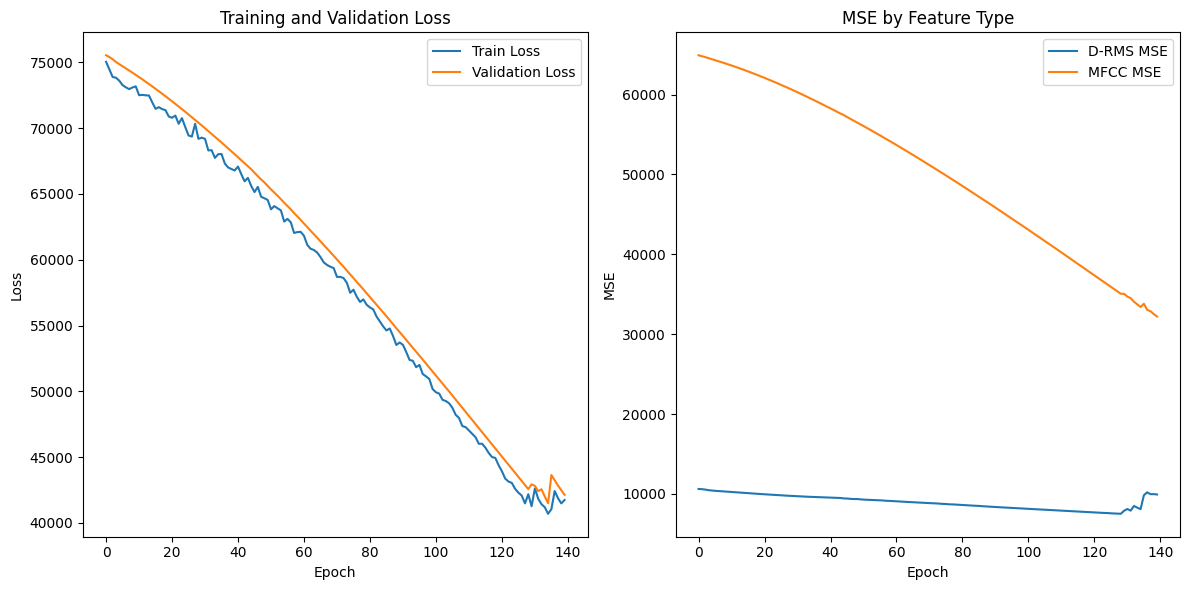

Transformer metrics (Label 0): {'FAR': np.float64(0.0), 'FRR': np.float64(0.23809523809410432), 'EER': np.float64(0.11904761904705216), 'ACC': np.float64(0.7619047619047619), 'F1': 0.8648648648648649, 'label': np.int64(0)}


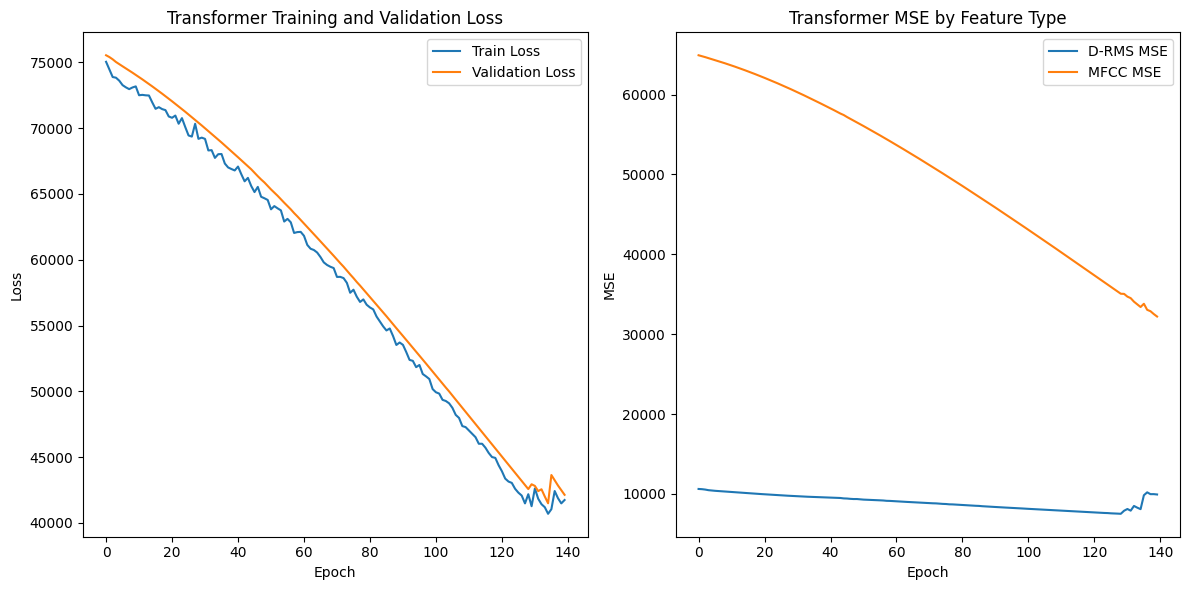


🌀 Training LSTMAutoencoder...
Epoch 1/300 - Train Loss: 75428.9427, Val Loss: 76672.0312, D-RMS MSE: 10666.5361, MFCC MSE: 66005.4922, D-RMS R2: -0.0696, MFCC R2: -0.0524
Epoch 2/300 - Train Loss: 75128.4245, Val Loss: 76092.6172, D-RMS MSE: 10631.5029, MFCC MSE: 65461.1172, D-RMS R2: -0.0660, MFCC R2: -0.0437
Epoch 3/300 - Train Loss: 74412.1146, Val Loss: 75666.7500, D-RMS MSE: 10576.9121, MFCC MSE: 65089.8516, D-RMS R2: -0.0606, MFCC R2: -0.0378
Epoch 4/300 - Train Loss: 73933.1328, Val Loss: 75374.9141, D-RMS MSE: 10519.7832, MFCC MSE: 64855.1289, D-RMS R2: -0.0548, MFCC R2: -0.0341
Epoch 5/300 - Train Loss: 73592.7760, Val Loss: 75159.2578, D-RMS MSE: 10471.7686, MFCC MSE: 64687.4844, D-RMS R2: -0.0500, MFCC R2: -0.0314
Epoch 6/300 - Train Loss: 73463.0599, Val Loss: 74975.4141, D-RMS MSE: 10434.7861, MFCC MSE: 64540.6289, D-RMS R2: -0.0463, MFCC R2: -0.0291
Epoch 7/300 - Train Loss: 73760.6745, Val Loss: 74790.7422, D-RMS MSE: 10387.6465, MFCC MSE: 64403.0898, D-RMS R2: -0.0416,

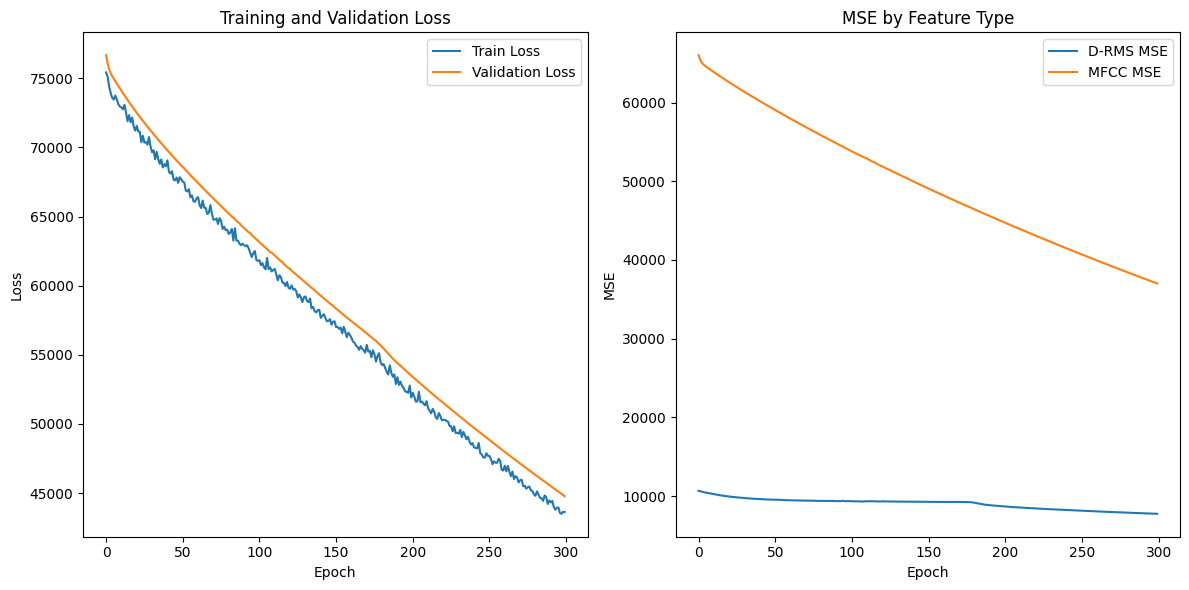

LSTM metrics (Label 0): {'FAR': np.float64(0.0), 'FRR': np.float64(0.23809523809410432), 'EER': np.float64(0.11904761904705216), 'ACC': np.float64(0.7619047619047619), 'F1': 0.8648648648648649, 'label': np.int64(0)}


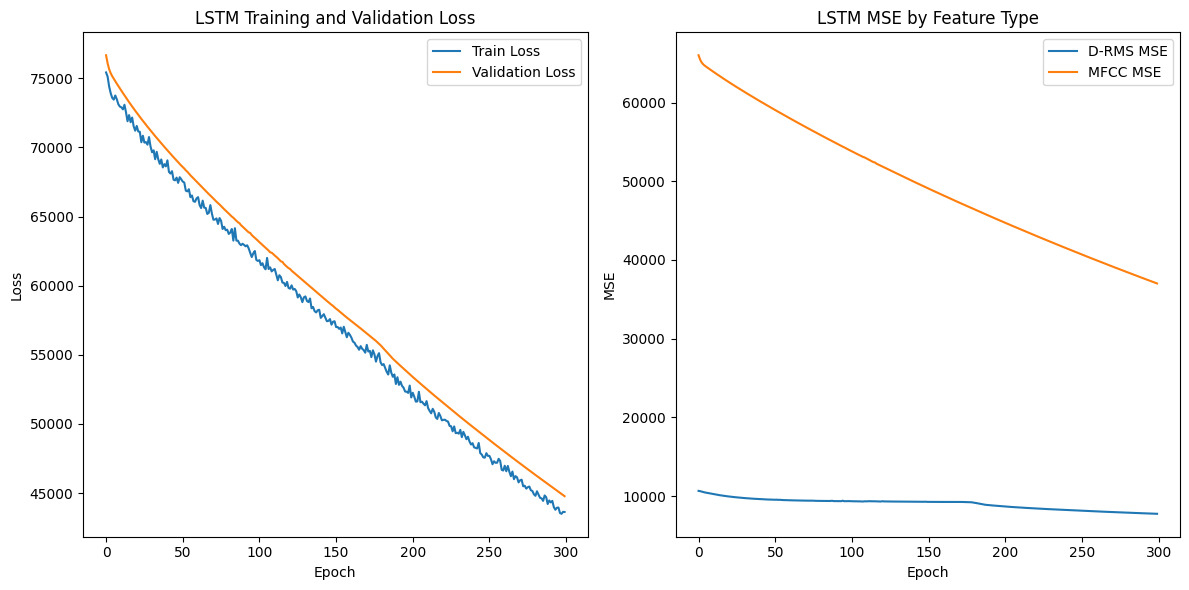


📊 Model Comparison Table:
     Label  Transformer FAR  LSTM FAR  Transformer FRR  LSTM FRR  \
0        0              0.0       0.0         0.238095  0.238095   
0  Average              0.0       0.0         0.238095  0.238095   

   Transformer EER  LSTM EER  Transformer ACC  LSTM ACC  Transformer F1  \
0         0.119048  0.119048         0.761905  0.761905        0.864865   
0         0.119048  0.119048         0.761905  0.761905        0.864865   

    LSTM F1  
0  0.864865  
0  0.864865  


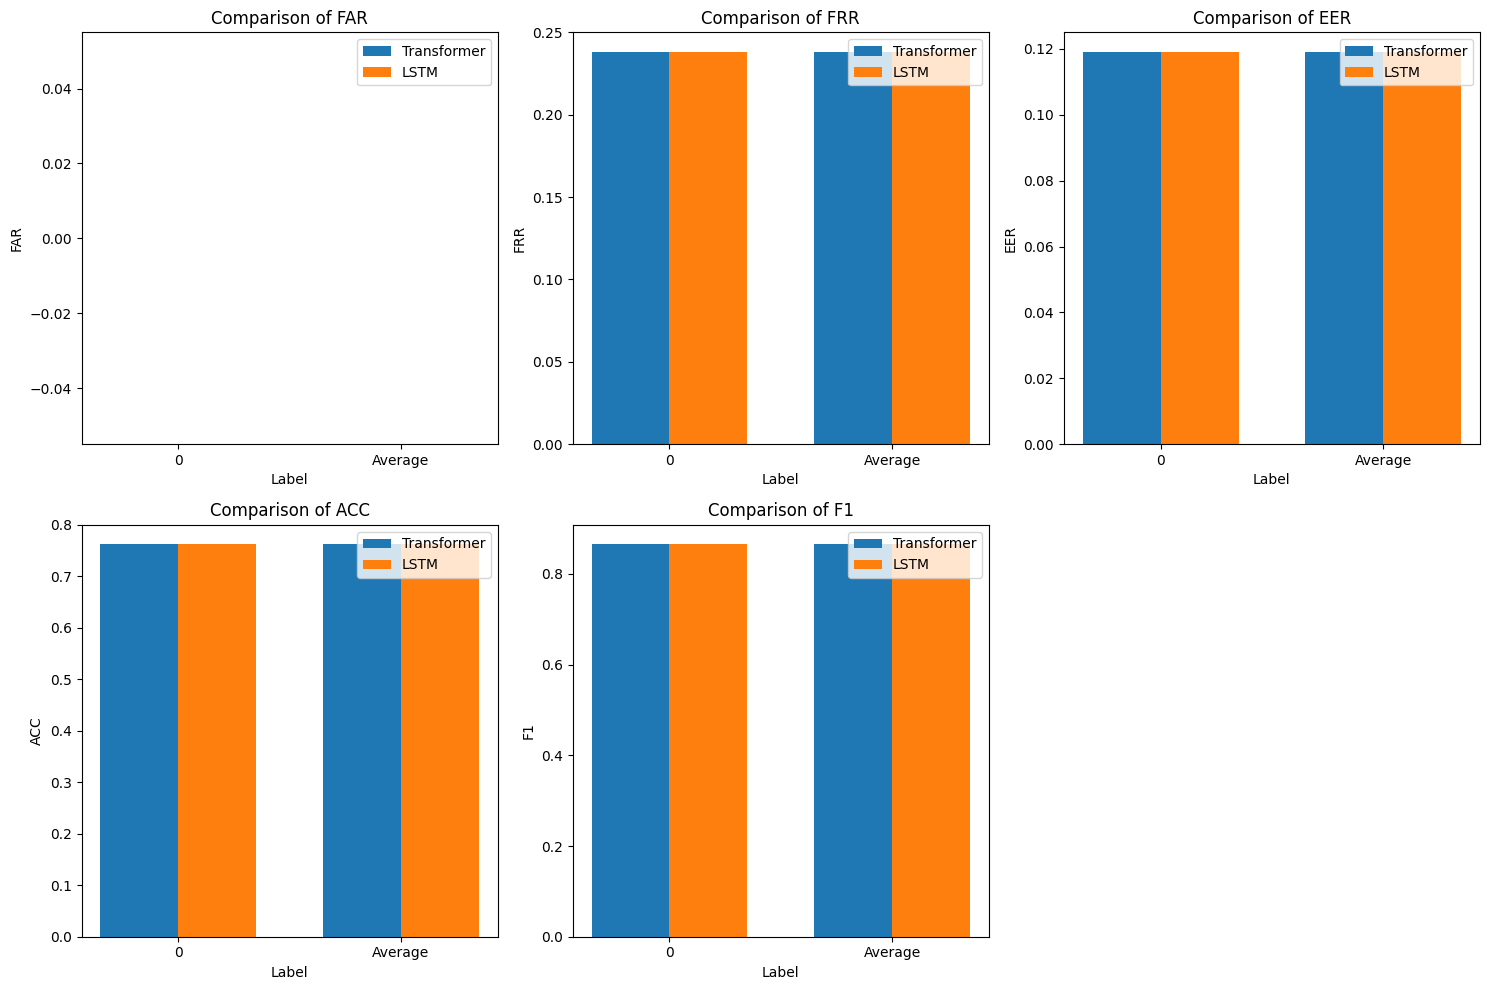

In [67]:
# Prepare your data
results = train_autoencoders_per_label(dataset, batch_size=32, num_epochs=300)